In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read in all results and combine into a single dataframe:

results_dir = ''
#results_dir = '/content/drive/MyDrive/Colab Notebooks/Reker Lab ML/results/'

df_ls = []
for ds in ['Tyro', 'Acetyl', 'Mono']:

    # Read CV results:
    #df = pd.read_csv(results_dir+ds+'-Mixture-CVAvg_stats.csv')
    df = pd.read_csv(results_dir+ds+'-ModelCVs.csv')
    df = df.loc[df['Train Set'].str.contains('Non-Natural')]
    df['Dataset'] = ds
    df['Test'] = 'nonNP'
    df_ls.append(df)

    # Read final model results:
    # Need to rename columns to ensure they match the CV results file
    df = pd.read_csv(results_dir+ds+'-Models.csv')\
           .rename(columns={'Descriptors' : 'Descriptor', 
                            'R2' : 'r2', 
                            'RMSD' : 'rmsd', 
                            'Bias' : 'bias', 
                            'SDEP' : 'sdep'})
    df['Dataset'] = ds
    df = df.loc[df['Train'].str.contains('_nonNP')]
    df['Test'] = 'NP'
    df_ls.append(df)

# Combine separate dataframes:
df = pd.concat(df_ls)\
       .drop(columns=['Fold', 'Train', 'Unnamed: 0', 'Index', 'Train Set'])

# Identify non-numeric columns and exclude them from aggregation
numeric_cols = df.select_dtypes(include=np.number).columns
df = df.groupby(['Test', 'Dataset', 'Descriptor', 'Model'])[numeric_cols] \
       .agg(['mean','std'])
#df_grouped.head()
df.head()

Number of Molecules            r2            \
                                             mean std      mean       std   
Test Dataset Descriptor Model                                               
NP   Acetyl  Both       RF                    NaN NaN -0.076189  0.018506   
                        SVR                   NaN NaN -0.005231  0.000000   
                        XGBR                  NaN NaN -0.123608  0.000000   
             Morgan     RF                    NaN NaN -0.086184  0.018904   
                        SVR                   NaN NaN -0.079529  0.000000   

                                   rmsd                bias            \
                                   mean       std      mean       std   
Test Dataset Descriptor Model                                           
NP   Acetyl  Both       RF     1.112815  0.009587  0.258682  0.012375   
                        SVR    1.075530  0.000000  0.194109  0.000000   
                        XGBR   1.137095  0.000000  0.126390  0.000000   
             Morgan     RF     1.117970  0.009708  0.220273  0.010670   
                        SVR    1.114568  0.000000  0.296141  0.000000   

                                   sdep            
                                   mean       std  
Test Dataset Descriptor Model                      
NP   Acetyl  Both       RF     1.082278  0.010431  
                        SVR    1.057869  0.000000  
                        XGBR   1.130049  0.000000  
             Morgan     RF     1.096030  0.007920  
                        SVR    1.074506  0.000000

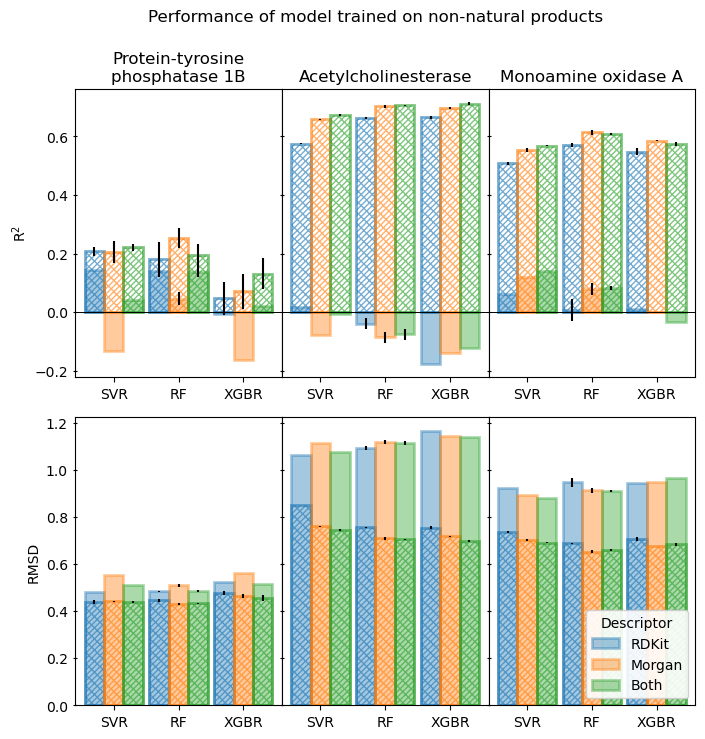

In [5]:
# Plot results:

fig, ax = plt.subplots(2, 3, figsize=(8, 8), sharey='row', 
                       gridspec_kw={'wspace' : 0, 
                                    'hspace' : 0.14})

bar_width = 0.3
models = ['SVR', 'RF', 'XGBR']
bar_colours = ['tab:blue', 'tab:orange', 'tab:green']

# Add axis line at y=0:
ax[0, 0].axhline(0, c='black', lw=0.7)
ax[0, 1].axhline(0, c='black', lw=0.7)
ax[0, 2].axhline(0, c='black', lw=0.7)

for s_i, stats in enumerate(['r2', 'rmsd']):
    for d_i, dataset in enumerate(['Tyro', 'Acetyl', 'Mono']):
        for i, desc in enumerate(['RDKit', 'Morgan', 'Both']):

            # Show CV test results on non-NPs:
            ax[s_i, d_i].bar(np.arange(len(df.loc[('nonNP', dataset, desc)].loc[models]))+bar_width*(i-1), 
                           height=df.loc[('nonNP', dataset, desc), (stats, 'mean')].loc[models], 
                           width=bar_width, 
                           # label=desc, 
                           alpha=0.6, 
                           # fc='empty', 
                           ec=bar_colours[i], 
                           fc=bar_colours[i], 
                           lw=2, 
                           fill=False, 
                           hatch='//////\\\\\\',
                           yerr=df.loc[('nonNP', dataset, desc), (stats, 'std')].loc[models]) # Add this line)

            # Show test results on NPs:
            ax[s_i, d_i].bar(np.arange(len(df.loc[('NP', dataset, desc)].loc[models]))+bar_width*(i-1), 
                           height=df.loc[('NP', dataset, desc), (stats, 'mean')].loc[models], 
                           width=bar_width, 
                           label=desc, 
                           alpha=0.4, 
                           lw=2, 
                           ec=bar_colours[i], #'black', 
                           fc=bar_colours[i],
                           yerr=df.loc[('NP', dataset, desc), (stats, 'std')].loc[models]) # Add this line)
            
        ax[s_i, d_i].set_xticks([0, 1, 2])
        ax[s_i, d_i].set_xticklabels(models)
        ax[s_i, d_i].tick_params(axis="y", direction="inout")

ax[0, 0].set_title('Protein-tyrosine\nphosphatase 1B')
ax[0, 1].set_title('Acetylcholinesterase')
ax[0, 2].set_title('Monoamine oxidase A')

ax[0, 0].set_ylabel('R$^{2}$')
ax[1, 0].set_ylabel('RMSD')

fig.suptitle('Performance of model trained on non-natural products')

# Modify legend:
plt.legend(loc='lower right', title='Descriptor', framealpha=0.9)

plt.savefig('Non-NP_results_bar_chart.png', dpi=400)
plt.show()